In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
from preprocess import tokenizeText, removeStopwords, removeSGML
from itertools import chain
from collections import Counter
import gensim
from sklearn import linear_model

In [2]:
cleaned = pd.read_csv("cleaned.csv")
images = pd.read_csv("images.csv")

In [3]:
cleaned.head(10)

,rating,cleaned,tweet,created_at,replies_count,retweets_count,likes_count,img_url
0,9,New view. Love the art. Presentation. Perspect...,New view. Love the art. Presentation. Perspect...,2021-03-17 16:24:35 EDT,3,2,62,https://pbs.twimg.com/media/EwtT4E7UUAAgt5w.jpg
1,9,Room Rater St Paddy’s Day Edition. Great wall ...,Room Rater St Paddy’s Day Edition. Great wall ...,2021-03-17 15:25:51 EDT,2,2,57,https://pbs.twimg.com/media/EwtGbzTUYAAxDiu.jpg
2,10,Doors of Dublin. The Dingus-the stuff that dre...,Doors of Dublin. The Dingus-the stuff that dre...,2021-03-17 15:19:53 EDT,7,4,123,https://pbs.twimg.com/media/EwtFESHVEAEYlzv.jpg
3,9,Good tight set up. Love the blue. Art. Flag. W...,Good tight set up. Love the blue. Art. Flag. W...,2021-03-17 13:46:47 EDT,1,1,60,https://pbs.twimg.com/media/EwsvwlOU8AQ5lOY.jpg
4,0,Dark. Will never escape the stank. Wrong about...,Dark. Will never escape the stank. Wrong about...,2021-03-17 13:11:17 EDT,35,38,846,https://pbs.twimg.com/media/Ewsnoq5U8AMxxAg.jpg
5,10,Room Rater St Paddy’s Day Update. @PhilipRucke...,Room Rater St Paddy’s Day Update. @PhilipRucke...,2021-03-17 12:34:31 EDT,10,12,620,https://pbs.twimg.com/media/EwsfN-yVoAAcVk8.jpg
6,6,Sun room set ups are tough. Raise camera. Late...,Sun room set ups are tough. Raise camera. Late...,2021-03-17 11:56:13 EDT,14,1,122,https://pbs.twimg.com/media/EwsWdHwVgAcPUqP.jpg
7,10,Room Rater Book Club. Love the art. Lighting. ...,Room Rater Book Club. Love the art. Lighting. ...,2021-03-17 11:49:52 EDT,1,4,87,https://pbs.twimg.com/media/EwsVABRVgAEJGvE.jpg
8,8,Ducks. Packers. Big plant. Well composed sport...,Ducks. Packers. Big plant. Well composed sport...,2021-03-17 11:23:46 EDT,2,1,49,https://pbs.twimg.com/media/EwsPBsuVoAQNL90.jpg
9,8,Well composed set up. Good spacing. Lower came...,Well composed set up. Good spacing. Lower came...,2021-03-17 11:08:35 EDT,2,2,49,https://pbs.twimg.com/media/EwsLjYDVEAIPjdu.jpg


In [4]:
images.head()

,img_url
0,https://pbs.twimg.com/media/EwtT4E7UUAAgt5w.jpg
1,https://pbs.twimg.com/media/EwtGbzTUYAAxDiu.jpg
2,https://pbs.twimg.com/media/EwtFESHVEAEYlzv.jpg
3,https://pbs.twimg.com/media/EwsvwlOU8AQ5lOY.jpg
4,https://pbs.twimg.com/media/Ewsnoq5U8AMxxAg.jpg


In [5]:
cleaned.iloc[0]["cleaned"]

'New view. Love the art. Presentation. Perspective. Light/lighting. Widen shot slightly.  @DavidJollyFL  '

In [26]:
cleaned.iloc[7]["cleaned"]

'Room Rater Book Club. Love the art. Lighting. Flowers. Arkansas Traveler.  @IAmSophiaNelson  '

In [7]:
# lowest rating
low_rating = cleaned[cleaned['rating'] == 0]
low_rating.head(3) # yields row 4, 20, 28

# semi low rating
semi_low_rating = cleaned[cleaned['rating'] == 3]
semi_low_rating.head(3) # yields row 75, 135, 153

# middle rating
middle_rating = cleaned[cleaned['rating'] == 5]
middle_rating.head(3) # yields rows 169, 240, 245

#semi middle rating
semi_middle_rating = cleaned[cleaned['rating'] == 7]
semi_middle_rating.head(3) # yields rows 37, 45, 69

# semi high rating
semi_high_rating = cleaned[cleaned['rating'] == 8]
semi_high_rating.head(3) # yields rows 8, 9, 17

# highest rating
highest_rating = cleaned[cleaned['rating'] == 10]
highest_rating.head(3) # yields rows 2, 5, 7


,rating,cleaned,tweet,created_at,replies_count,retweets_count,likes_count,img_url
2,10,Doors of Dublin. The Dingus-the stuff that dre...,Doors of Dublin. The Dingus-the stuff that dre...,2021-03-17 15:19:53 EDT,7,4,123,https://pbs.twimg.com/media/EwtFESHVEAEYlzv.jpg
5,10,Room Rater St Paddy’s Day Update. @PhilipRucke...,Room Rater St Paddy’s Day Update. @PhilipRucke...,2021-03-17 12:34:31 EDT,10,12,620,https://pbs.twimg.com/media/EwsfN-yVoAAcVk8.jpg
7,10,Room Rater Book Club. Love the art. Lighting. ...,Room Rater Book Club. Love the art. Lighting. ...,2021-03-17 11:49:52 EDT,1,4,87,https://pbs.twimg.com/media/EwsVABRVgAEJGvE.jpg


In [8]:
len(cleaned)

12619

(0, 10)

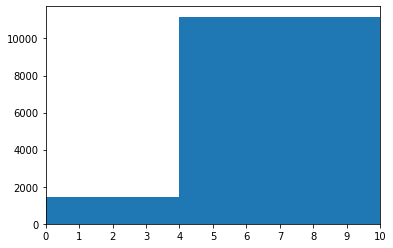

In [9]:
plt.hist(cleaned["rating"], bins = 10)
plt.xticks(range(1000))
plt.xlim(0, 10)

## **BASIC PREPROCESSING:**
    * Removed Punctuation
    * Removed Stopwords

In [10]:
preprocessed = cleaned[['rating','cleaned']]

In [11]:
preprocessed.head(10)

,rating,cleaned
0,9,New view. Love the art. Presentation. Perspect...
1,9,Room Rater St Paddy’s Day Edition. Great wall ...
2,10,Doors of Dublin. The Dingus-the stuff that dre...
3,9,Good tight set up. Love the blue. Art. Flag. W...
4,0,Dark. Will never escape the stank. Wrong about...
5,10,Room Rater St Paddy’s Day Update. @PhilipRucke...
6,6,Sun room set ups are tough. Raise camera. Late...
7,10,Room Rater Book Club. Love the art. Lighting. ...
8,8,Ducks. Packers. Big plant. Well composed sport...
9,8,Well composed set up. Good spacing. Lower came...


In [12]:
def preprocess(tweet, stopwords):
    tweet = tokenizeText(str(tweet))
    tokens = []
    for token in tweet: 
        if token not in string.punctuation: 
            tokens.append(token.lower())
            
    if stopwords: 
        tokens = removeStopwords(tokens)
    
    return tokens
    

In [13]:
preprocessed['tokenized'] = preprocessed['cleaned'].apply(lambda x : preprocess(x, False))
preprocessed['stopwords'] = preprocessed['cleaned'].apply(lambda x : preprocess(x, True))

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [14]:
preprocessed

,rating,cleaned,tokenized,stopwords
0,9,New view. Love the art. Presentation. Perspect...,"[new, view, love, the, art, presentation, pers...","[new, view, love, art, presentation, perspecti..."
1,9,Room Rater St Paddy’s Day Edition. Great wall ...,"[room, rater, st, paddy’s, day, edition, great...","[room, rater, st, paddy’s, day, edition, great..."
2,10,Doors of Dublin. The Dingus-the stuff that dre...,"[doors, of, dublin, the, dingus-the, stuff, th...","[doors, dublin, dingus-the, stuff, dreams, mad..."
3,9,Good tight set up. Love the blue. Art. Flag. W...,"[good, tight, set, up, love, the, blue, art, f...","[good, tight, set, up, love, blue, art, flag, ..."
4,0,Dark. Will never escape the stank. Wrong about...,"[dark, will, never, escape, the, stank, wrong,...","[dark, never, escape, stank, wrong, about, eve..."
...,...,...,...,...
12614,8,The blue works. Not just books a plus. Good us...,"[the, blue, works, not, just, books, a, plus, ...","[blue, works, not, just, books, plus, good, us..."
12615,2,This is the “I’ll just put on sweatpants” of S...,"[this, is, the, “i’ll, just, put, on, sweatpan...","[“i’ll, just, put, sweatpants”, skype, rooms]"
12616,3,All books. Too dark. Little in way of personal...,"[all, books, too, dark, little, in, way, of, p...","[books, too, dark, little, way, personal, style]"
12617,4,Books always a must but a little too obvious f...,"[books, always, a, must, but, a, little, too, ...","[books, always, must, little, too, obvious, su..."


In [15]:
all_words = list(chain(*preprocessed['stopwords']))

In [16]:
len(all_words)

140437

# **Utilizing LDA Topic Modeling**
Following this paper: https://core.ac.uk/download/pdf/210609036.pdf

**1. Baseline Sentient Model:**
   1. Retrieve list of negative + positive opinion/sentiment words
   2. Count the number of positive + negative words in each model
   3. Positive + Negative Scores are used as features for rating prediction

**2. Only LDA Topic Model:** 
   1. Fits data into LDA to get topic models, topic model is trained
   2. Topic model is applied back to training reviews + each review gets topic
      distribution/probabilities
   3. Topic probabilities are used as features for rating prediction + fitted
      into linear regression model
        
**3. Combined Sentiment + LDA Topic Model**
   1. Compute Positive + Negative Scores e.x. (5, 3)
   2. Compute Topic Distributions/Probabilities e.x. (0.2, 0.4, 0.4)
   3. Product of (1) and (2) are features for rating prediction
   e.x. 5 * 0.2, 5 * 0.4, 5 * 0.4, 3 * 0.2, 3 * 0.4, 3 * 0.4
        
**4. All Features from Previous 3 Models**
   1. e.x.: positve score, negative score, topic probabilities, product of 
      positive + negative scores with topic probabilities
             

## 2. Only LDA

In [17]:
from gensim.models.ldamodel import LdaModel
from gensim.corpora import Dictionary

In [18]:
# Creating bag of words
token_dict = Dictionary(preprocessed.stopwords)
bag_of_words = [token_dict.doc2bow(tweet) for tweet in preprocessed['stopwords']]
#token_dict.token2id

In [19]:
# Fitting data into LDA (5 TOPICS)
lda_5 = LdaModel(bag_of_words, 
                    num_topics = 5,
                    id2word = token_dict,
                    random_state = 1, 
                    passes = 10)

lda_5.show_topics()

[(0,
  '0.020*"well" + 0.020*"art" + 0.017*"love" + 0.015*"we" + 0.013*"hostage" + 0.011*"video" + 0.010*"points" + 0.009*"lit" + 0.008*"plant" + 0.008*"nice"'),
 (1,
  '0.059*"room" + 0.029*"rater" + 0.016*"has" + 0.014*"update" + 0.012*"we" + 0.008*"it’s" + 0.007*"new" + 0.006*"pineapple" + 0.006*"still" + 0.005*"now"'),
 (2,
  '0.039*"room" + 0.023*"skype" + 0.020*"rooms" + 0.014*"rater" + 0.012*"great" + 0.009*"day" + 0.008*"historic" + 0.007*"cord" + 0.007*"happy" + 0.006*"violation"'),
 (3,
  '0.014*"we" + 0.009*"not" + 0.009*"don’t" + 0.008*"it’s" + 0.008*"like" + 0.005*"beams" + 0.005*"\u2066" + 0.004*"gets" + 0.004*"has" + 0.004*"oh"'),
 (4,
  '0.038*"art" + 0.026*"love" + 0.019*"add" + 0.018*"good" + 0.018*"plant" + 0.015*"light" + 0.014*"nice" + 0.013*"camera" + 0.013*"up" + 0.013*"great"')]

In [20]:
# Fitting data into LDA (10 TOPICS)
lda_10 = LdaModel(bag_of_words, 
                    num_topics = 10,
                    id2word = token_dict,
                    random_state = 1, 
                    passes = 10)

lda_10.show_topics()

[(0,
  '0.032*"we" + 0.023*"it’s" + 0.017*"like" + 0.016*"room" + 0.013*"not" + 0.010*"covid" + 0.010*"too" + 0.009*"cabin" + 0.008*"has" + 0.008*"just"'),
 (1,
  '0.057*"camera" + 0.033*"raise" + 0.028*"art" + 0.019*"back" + 0.017*"reframe" + 0.016*"add" + 0.014*"out" + 0.013*"plant" + 0.012*"left" + 0.012*"right"'),
 (2,
  '0.025*"works" + 0.014*"framing" + 0.014*"being" + 0.011*"pretty" + 0.011*"not" + 0.010*"simple" + 0.010*"give" + 0.009*"together" + 0.008*"effective" + 0.008*"really"'),
 (3,
  '0.033*"don’t" + 0.019*"not" + 0.018*"that’s" + 0.016*"ok" + 0.015*"doesn’t" + 0.013*"he’s" + 0.012*"it’s" + 0.012*"sure" + 0.011*"oh" + 0.011*"thing"'),
 (4,
  '0.059*"we" + 0.026*"see" + 0.021*"like" + 0.020*"so" + 0.015*"more" + 0.012*"room" + 0.010*"can" + 0.010*"better" + 0.009*"love" + 0.009*"would"'),
 (5,
  '0.112*"room" + 0.060*"rater" + 0.031*"skype" + 0.027*"rooms" + 0.025*"has" + 0.023*"update" + 0.013*"day" + 0.012*"best" + 0.012*"great" + 0.010*"one"'),
 (6,
  '0.031*"room" + 

In [21]:
# Fitting data into LDA (20 TOPICS)
lda_20 = LdaModel(bag_of_words, 
                    num_topics = 20,
                    id2word = token_dict,
                    random_state = 1, 
                    passes = 10)

lda_20.show_topics()

[(7,
  '0.051*"books" + 0.038*"point" + 0.032*"great" + 0.030*"color" + 0.028*"love" + 0.024*"lighting" + 0.021*"nice" + 0.021*"perfect" + 0.016*"colors" + 0.016*"good"'),
 (8,
  '0.102*"art" + 0.068*"love" + 0.052*"plant" + 0.042*"add" + 0.041*"light" + 0.033*"lamp" + 0.026*"depth" + 0.025*"great" + 0.021*"work" + 0.021*"good"'),
 (16,
  '0.042*"office" + 0.034*"no" + 0.020*"flag" + 0.020*"house" + 0.020*"we’d" + 0.018*"about" + 0.018*"map" + 0.016*"thing" + 0.016*"what’s" + 0.014*"quite"'),
 (19,
  '0.095*"up" + 0.058*"set" + 0.042*"good" + 0.035*"book" + 0.035*"nice" + 0.027*"shelf" + 0.020*"bookshelf" + 0.020*"little" + 0.019*"add" + 0.019*"plant"'),
 (2,
  '0.074*"two" + 0.039*"1" + 0.028*"got" + 0.028*"3" + 0.025*"frames" + 0.021*"home" + 0.020*"does" + 0.019*"made" + 0.017*"between" + 0.016*"long"'),
 (9,
  '0.134*"well" + 0.052*"lit" + 0.034*"art" + 0.025*"love" + 0.025*"color" + 0.021*"solid" + 0.018*"wall" + 0.015*"cord" + 0.015*"done" + 0.015*"violation"'),
 (1,
  '0.040*"th

In [27]:
# Applying Topic Models back to each review in dataset

# NEGATIVE RATING (0)
tweet = 'Dark. Will never escape the stank. Wrong about everything. May be on a bender.  @larry_kudlow  '
processed = preprocess(tweet, True)

new_bow = token_dict.doc2bow(processed)
print(new_bow)
print(lda_10.get_document_topics(new_bow))

# POSITIVE RATING (10)
tweet = 'Room Rater Book Club. Love the art. Lighting. Flowers. Arkansas Traveler.  @IAmSophiaNelson  '
processed = preprocess(tweet, True)

new_bow = token_dict.doc2bow(processed)
print(new_bow)
print(lda_10.get_document_topics(new_bow))

[(48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1)]
[(1, 0.11384911), (3, 0.09676142), (4, 0.6427895), (8, 0.09629589)]
[(0, 1), (3, 1), (4, 1), (22, 1), (23, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1)]
[(0, 0.10914366), (5, 0.28950176), (7, 0.23826946), (9, 0.30839384)]


In [82]:
def extract_topic_probabilities(tokens):
    bow = token_dict.doc2bow(tokens)
    topic_probs = lda_5.get_document_topics(bow)
    probs = []
        
    probs_dict = dict(topic_probs)
        
    for i in range (0, 5):
        if i not in probs_dict: 
            probs.append(0)
        else: 
            probs.append(probs_dict[i])
    
    return probs
    

In [57]:
extract_topic_probabilities(processed)

[0.10914416, 0, 0, 0, 0, 0.28950244, 0, 0.23829052, 0, 0.30837163]

In [58]:
preprocessed['lda_10_probs'] = preprocessed['stopwords'].apply(lambda x : extract_topic_probabilities(x))

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [83]:
preprocessed['lda_5_probs'] = preprocessed['stopwords'].apply(lambda x : extract_topic_probabilities(x))

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [84]:
preprocessed

,rating,cleaned,tokenized,stopwords,lda_10_probs,lda_5_probs
0,9,New view. Love the art. Presentation. Perspect...,"[new, view, love, the, art, presentation, pers...","[new, view, love, art, presentation, perspecti...","[0.09156639, 0.24203835, 0, 0, 0, 0, 0, 0, 0, ...","[0.015527121, 0.015556218, 0.015409035, 0.0153..."
1,9,Room Rater St Paddy’s Day Edition. Great wall ...,"[room, rater, st, paddy’s, day, edition, great...","[room, rater, st, paddy’s, day, edition, great...","[0, 0, 0, 0, 0, 0.18262146, 0, 0, 0.47370574, ...","[0.011549193, 0.2766795, 0.17538297, 0.0111823..."
2,10,Doors of Dublin. The Dingus-the stuff that dre...,"[doors, of, dublin, the, dingus-the, stuff, th...","[doors, dublin, dingus-the, stuff, dreams, mad...","[0.6322252, 0, 0, 0, 0, 0, 0, 0, 0, 0.31029245]","[0.8890318, 0.014607806, 0.014725708, 0.014365..."
3,9,Good tight set up. Love the blue. Art. Flag. W...,"[good, tight, set, up, love, the, blue, art, f...","[good, tight, set, up, love, blue, art, flag, ...","[0, 0.1779961, 0, 0, 0, 0, 0, 0.44206774, 0, 0...","[0.015653592, 0.015481074, 0.01546005, 0.01550..."
4,0,Dark. Will never escape the stank. Wrong about...,"[dark, will, never, escape, the, stank, wrong,...","[dark, never, escape, stank, wrong, about, eve...","[0, 0.11381874, 0, 0.09676087, 0.64282113, 0, ...","[0.016867774, 0.01694735, 0.017325774, 0.63842..."
...,...,...,...,...,...,...
12614,8,The blue works. Not just books a plus. Good us...,"[the, blue, works, not, just, books, a, plus, ...","[blue, works, not, just, books, plus, good, us...","[0.010004622, 0.010001314, 0.20998992, 0.01000...","[0.020481678, 0.020077424, 0.020132212, 0.0202..."
12615,2,This is the “I’ll just put on sweatpants” of S...,"[this, is, the, “i’ll, just, put, on, sweatpan...","[“i’ll, just, put, sweatpants”, skype, rooms]","[0.15713212, 0.01428883, 0.4428128, 0.01428746...","[0.028653761, 0.028701052, 0.8843602, 0.028866..."
12616,3,All books. Too dark. Little in way of personal...,"[all, books, too, dark, little, in, way, of, p...","[books, too, dark, little, way, personal, style]","[0.32287815, 0.012503419, 0.01250102, 0.012500...","[0.025479686, 0.025074633, 0.1582538, 0.348169..."
12617,4,Books always a must but a little too obvious f...,"[books, always, a, must, but, a, little, too, ...","[books, always, must, little, too, obvious, su...","[0, 0, 0.2819565, 0.10524834, 0, 0, 0, 0.42988...","[0.81791776, 0.01831482, 0.018379774, 0.126744..."


In [67]:
lda_features_df = preprocessed[['rating', 'lda_10_probs']]
lda_features_df[['0','1', '2', '3', '4', '5', '6', '7', '8', '9']] = pd.DataFrame(lda_features_df.lda_10_probs.tolist(), index=lda_features_df.index)
lda_features_df = lda_features_df[['rating', '0','1', '2', '3', '4', '5', '6', '7', '8', '9']]
lda_features_df



/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,rating,0,1,2,3,4,5,6,7,8,9
0,9,0.091566,0.242038,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.612527
1,9,0.000000,0.000000,0.000000,0.000000,0.000000,0.182621,0.000000,0.000000,0.473706,0.304690
2,10,0.632225,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.310292
3,9,0.000000,0.177996,0.000000,0.000000,0.000000,0.000000,0.000000,0.442068,0.000000,0.321643
4,0,0.000000,0.113819,0.000000,0.096761,0.642821,0.000000,0.000000,0.000000,0.096295,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
12614,8,0.010005,0.010001,0.209990,0.010003,0.010003,0.010000,0.010000,0.010006,0.010001,0.709990
12615,2,0.157132,0.014289,0.442813,0.014287,0.014289,0.300034,0.014287,0.014291,0.014287,0.014289
12616,3,0.322878,0.012503,0.012501,0.012501,0.012503,0.012502,0.137486,0.452123,0.012501,0.012502
12617,4,0.000000,0.000000,0.281956,0.105248,0.000000,0.000000,0.000000,0.429887,0.000000,0.128320


In [86]:
lda_features_df_5 = preprocessed[['rating', 'lda_5_probs']]
lda_features_df_5[['0','1', '2', '3', '4']] = pd.DataFrame(lda_features_df_5.lda_5_probs.tolist(), index=lda_features_df_5.index)
lda_features_df_5 = lda_features_df_5[['rating', '0','1', '2', '3', '4']]
lda_features_df_5

/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,rating,0,1,2,3,4
0,9,0.015527,0.015556,0.015409,0.015388,0.938120
1,9,0.011549,0.276679,0.175383,0.011182,0.525206
2,10,0.889032,0.014608,0.014726,0.014366,0.067269
3,9,0.015654,0.015481,0.015460,0.015504,0.937901
4,0,0.016868,0.016947,0.017326,0.638420,0.310439
...,...,...,...,...,...,...
12614,8,0.020482,0.020077,0.020132,0.020267,0.919041
12615,2,0.028654,0.028701,0.884360,0.028867,0.029418
12616,3,0.025480,0.025075,0.158254,0.348170,0.443022
12617,4,0.817918,0.018315,0.018380,0.126745,0.018643


In [81]:
# fitting linear regression model on training data (10 TOPICS)
train_size = int(0.7 * len(lda_features_df))
train = lda_features_df[:train_size]
test = lda_features_df[train_size:]

X_all = lda_features_df[['0','1', '2', '3', '4', '5', '6', '7', '8', '9']]
y_all = lda_features_df['rating']

X_train = train[['0','1', '2', '3', '4', '5', '6', '7', '8', '9']]
y_train = train['rating']

X_test = test[['0','1', '2', '3', '4', '5', '6', '7', '8', '9']]
y_test = test['rating']


lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)

lm.score(X_test, y_test)

0.04729494007571977

In [87]:
# fitting linear regression model on training data (5 TOPICS)
train_size = int(0.7 * len(lda_features_df_5))
train = lda_features_df_5[:train_size]
test = lda_features_df_5[train_size:]

X_all = lda_features_df_5[['0','1', '2', '3', '4']]
y_all = lda_features_df_5['rating']

X_train = train[['0','1', '2', '3', '4']]
y_train = train['rating']

X_test = test[['0','1', '2', '3', '4',]]
y_test = test['rating']


lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)

lm.score(X_test, y_test)

-0.052410074085618374

In [ ]:
#lol